# Access and Download the CHIPRS Data

In [ ]:
! pip install s3fs --quiet
! pip install rioxarray --quiet
! pip install zarr
! pip install cartopy
! pip install xarray


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 797.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 467.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 32.8 MB/s eta 0:00:00


In [3]:
import s3fs
import xarray as xr
import rioxarray
import geopandas as gpd
from shapely.geometry import mapping
import os
from tqdm import tqdm
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import imageio
import os
from tqdm import tqdm
import numpy as np
warnings.filterwarnings("ignore")

## Getting the Access from AWS Africa thanks to DEA 

In [4]:
os.environ["AWS_NO_SIGN_REQUEST"] = "YES"
os.environ["AWS_REQUEST_PAYER"] = "requester"  # sometimes needed

# Tell GDAL/rasterio which region the bucket is in
os.environ["AWS_REGION"] = "af-south-1"
os.environ["AWS_DEFAULT_REGION"] = "af-south-1"

# Optional: avoid using virtual-hosted-style URLs (safeguard)
os.environ["AWS_S3_ADDRESSING_STYLE"] = "path"

In [5]:
fs = s3fs.S3FileSystem(anon=True, client_kwargs={"region_name": "af-south-1"})


In [6]:
root = 'deafrica-input-datasets/rainfall_chirps_daily'
years = [y.split('/')[-1] for y in fs.ls(root) if y.split('/')[-1].isdigit()]
years = sorted(years)
print("Available years:", years)

Available years: ['1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']


In [7]:
all_files = []

for year in years:
    for m in range(1, 13):
        prefix = f"{root}/{year}/{str(m).zfill(2)}"
        if fs.exists(prefix):
            all_files.extend(fs.ls(prefix))

print(f"Total CHIRPS daily files found: {len(all_files)}")

Total CHIRPS daily files found: 32322


In [ ]:
all_files = [f for f in all_files if f.endswith(".tif")]
print(f"Total GeoTIFFs: {len(all_files)}")

In [ ]:

# Load shapefile (should be in EPSG:4326, or reproject it)
gdf = gpd.read_file("/content/Namibia_South.shp").to_crs("EPSG:4326")
aoi_geom = gdf.geometry.values[0]  # assuming one polygon
geojson_aoi = [mapping(aoi_geom)]  # convert to GeoJSON format

In [ ]:
url = 's3://deafrica-input-datasets/rainfall_chirps_daily/2024/05/chirps-v2.0_2024.05.01.tif'

da = rioxarray.open_rasterio(url, masked=True).squeeze(drop=True)
da.name = 'precipitation'
da.rio.write_crs("EPSG:4326", inplace=True)
da.plot()

## This may take alot of time 

In [ ]:
dataarrays = []

for path in tqdm(all_files, desc="Processing CHIRPS files"):
    try:
        url = f's3://{path}'
        filename = os.path.basename(path)

        # Extract date from filename: chirps-v2.0_1981.01.01.tif → 1981-01-01
        date_str = filename.split('_')[-1].replace('.tif', '')
        parts = date_str.split('.')
        if len(parts) != 3:
            continue
        date = '-'.join(parts)

        # Open and prepare the raster
        da = rioxarray.open_rasterio(url, masked=True).squeeze(drop=True)
        da.name = 'precipitation'
        da = da.expand_dims(time=[date])
        da.rio.write_crs("EPSG:4326", inplace=True)

        # Clip to shapefile AOI
        da = da.rio.clip(geojson_aoi, crs="EPSG:4326")

        dataarrays.append(da)

    except Exception as e:
        print(f"❌ Skipped {path}: {e}")

Processing CHIRPS files: 100%|██████████| 16100/16100 [3:34:01<00:00,  1.25it/s]


## To Xarray Format & Checking the data

In [ ]:
cube = xr.concat(dataarrays, dim="time")
cube
# cube['time'] = xr.decode_cf(cube).time
# cube.name = 'precipitation'

<xarray.DataArray 'precipitation' (time: 16100, y: 54, x: 111)> Size: 386MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time         (time) object 129kB '1981-01-01' '1981-01-02' ... '2025-05-31'
  * x            (x) float64 888B 14.48 14.53 14.58 14.63 ... 19.88 19.93 19.98
  * y            (y) float64 432B -23.18 -23.23 -23.28 ... -25.73 -25.78 -25.83
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_DOCUMENTNAME:      /home/sandbox/chirps/v2.0/daily_downscaled_by_...
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_SOFTWARE:          IDL 8.5, Exelis Visual Information Solutions, ...
    TIFFTAG_DATETIME:          2015:09:01 17:10:36
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    OVR_RESAMPLING_ALG:        NEAREST
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0

In [ ]:
cube['time'] = xr.DataArray(pd.to_datetime(cube.time.values), dims="time")


In [ ]:
print(cube.time)


<xarray.DataArray 'time' (time: 16100)> Size: 129kB
array(['1981-01-01T00:00:00.000000000', '1981-01-02T00:00:00.000000000',
       '1981-01-03T00:00:00.000000000', ..., '2025-05-29T00:00:00.000000000',
       '2025-05-30T00:00:00.000000000', '2025-05-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 129kB 1981-01-01 ... 2025-05-31


In [ ]:
cube.to_zarr("chirps_daily_all_years_aoi.zarr", mode="w")


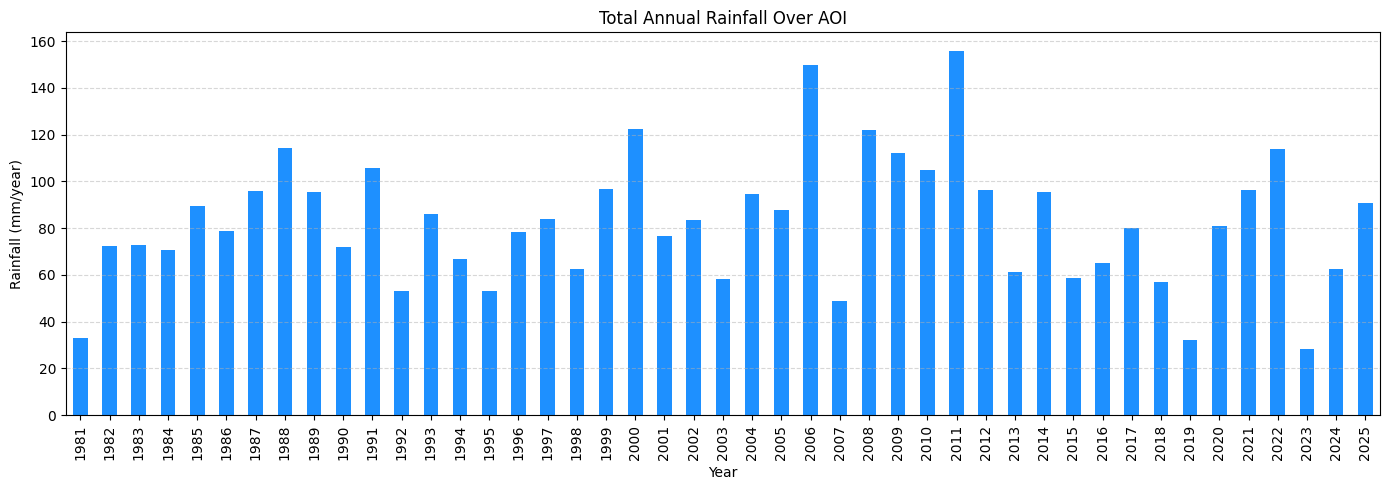

In [ ]:
annual_total = cube.groupby("time.year").sum(dim="time")
annual_mean = annual_total.mean(dim=["x", "y"])
plt.figure(figsize=(14, 5))
annual_mean.to_series().plot.bar(color='dodgerblue')

plt.title("Total Annual Rainfall Over AOI")
plt.ylabel("Rainfall (mm/year)")
plt.xlabel("Year")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
plt.show()

## Exporting the data

In [ ]:
cube.to_zarr("chirps_daily_all_years_aoi.zarr", mode="w")
cube.to_netcdf("chirps_daily_all_years_aoi.nc")


In [ ]:

shutil.make_archive("chirps_zarr", 'zip', "chirps_daily_all_years_aoi.zarr")


'/content/chirps_zarr.zip'

In [ ]:
from google.colab import files
files.download("chirps_zarr.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>